In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:97% !important; }</style>"))

import jupyternotify
ip = get_ipython()
ip.register_magics(jupyternotify.JupyterNotifyMagics)

import scoring as score # para hacer los reportes de puntajes
from time import time

from sklearn import preprocessing
from sklearn.ensemble import RandomForestClassifier,RandomForestRegressor
from sklearn.preprocessing import StandardScaler  
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, RandomizedSearchCV, ShuffleSplit, train_test_split

properati = pd.read_csv('datos/caba_para_mapa.csv',error_bad_lines=False)

<IPython.core.display.Javascript object>

# RF Clasificador Casas

In [58]:
properati = properati.loc[properati['property_type'] == 'house']
properati.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2751 entries, 4 to 48322
Data columns (total 26 columns):
created_on                    2751 non-null object
property_type                 2751 non-null object
place_name                    2751 non-null object
state_name                    2751 non-null object
lat-lon                       2751 non-null object
lat                           2751 non-null float64
lon                           2751 non-null float64
price                         2751 non-null float64
currency                      2751 non-null object
price_aprox_local_currency    2751 non-null float64
price_aprox_usd               2751 non-null float64
surface_total_in_m2           2751 non-null float64
surface_covered_in_m2         2751 non-null float64
price_usd_per_m2              2751 non-null float64
price_per_m2                  2751 non-null float64
floor                         1 non-null float64
rooms                         1134 non-null float64
expenses         

In [3]:
#paso features con strings a numericos
le_barrio = preprocessing.LabelEncoder()
barrios=properati['place_name']
le_barrio.fit(barrios)
properati['place_name'] = le_barrio.transform(barrios)

le_divisa = preprocessing.LabelEncoder()
divisa=properati['currency']
le_divisa.fit(divisa)
properati['currency'] = le_divisa.transform(divisa)

le_tipo = preprocessing.LabelEncoder()
tipos_prop=properati['property_type']
le_tipo.fit(tipos_prop)
properati['property_type'] = le_tipo.transform(tipos_prop)

###  Agrego features

### Pruebo con np.histogram

In [4]:
cant_buckets = 500

#buckets
cantidad,rango = np.histogram(properati['price_per_m2'], bins=cant_buckets)
print rango
properati['categories_by_price']=pd.cut(properati['price_per_m2'],rango,labels=np.arange(cant_buckets),include_lowest=True)
properati['price_range']=pd.cut(properati['price_per_m2'],rango)

properati.loc[properati['categories_by_price']!=properati['categories_by_price']]
#properati['categories_by_price']=pd.qcut(x=properati['price_per_m2'],q=cant_buckets,labels=np.arange(cant_buckets))

[     0.      199.97    399.94    599.91    799.88    999.85   1199.82
   1399.79   1599.76   1799.73   1999.7    2199.67   2399.64   2599.61
   2799.58   2999.55   3199.52   3399.49   3599.46   3799.43   3999.4
   4199.37   4399.34   4599.31   4799.28   4999.25   5199.22   5399.19
   5599.16   5799.13   5999.1    6199.07   6399.04   6599.01   6798.98
   6998.95   7198.92   7398.89   7598.86   7798.83   7998.8    8198.77
   8398.74   8598.71   8798.68   8998.65   9198.62   9398.59   9598.56
   9798.53   9998.5   10198.47  10398.44  10598.41  10798.38  10998.35
  11198.32  11398.29  11598.26  11798.23  11998.2   12198.17  12398.14
  12598.11  12798.08  12998.05  13198.02  13397.99  13597.96  13797.93
  13997.9   14197.87  14397.84  14597.81  14797.78  14997.75  15197.72
  15397.69  15597.66  15797.63  15997.6   16197.57  16397.54  16597.51
  16797.48  16997.45  17197.42  17397.39  17597.36  17797.33  17997.3
  18197.27  18397.24  18597.21  18797.18  18997.15  19197.12  19397.09
  19597.

,created_on,property_type,place_name,state_name,lat-lon,lat,lon,price,currency,price_aprox_local_currency,...,properati_url,description,title,dist_a_subte,dist_a_tren,dist_a_univ,dist_a_villa,dist_a_zona_anegada,categories_by_price,price_range


In [5]:
#lo casteo a float porque si no tira error 
properati['categories_by_price']=properati['categories_by_price'].astype(np.float64) 

properati.loc[:,('created_on')] = pd.to_datetime(properati['created_on'])
properati['anio'] = [x.year for x in properati['created_on'] ]

properati.loc[:,'is_new']=properati.loc[:,'description'].str.lower().str.contains('estrenar')

properati.groupby('categories_by_price').count().sort_values('created_on')

,created_on,property_type,place_name,state_name,lat-lon,lat,lon,price,currency,price_aprox_local_currency,...,description,title,dist_a_subte,dist_a_tren,dist_a_univ,dist_a_villa,dist_a_zona_anegada,price_range,anio,is_new
categories_by_price,,,,,,,,,,,,,,,,,,,,,
440.0,2,2,2,2,2,2,2,2,2,2,...,2,2,2,2,2,2,2,2,2,2
442.0,2,2,2,2,2,2,2,2,2,2,...,2,2,2,2,2,2,2,2,2,2
37.0,3,3,3,3,3,3,3,3,3,3,...,3,3,3,3,3,3,3,3,3,3
495.0,3,3,3,3,3,3,3,3,3,3,...,3,3,3,3,3,3,3,3,3,3
487.0,3,3,3,3,3,3,3,3,3,3,...,3,3,3,3,3,3,3,3,3,3
443.0,5,5,5,5,5,5,5,5,5,5,...,5,5,5,5,5,5,5,5,5,5
483.0,5,5,5,5,5,5,5,5,5,5,...,5,5,5,5,5,5,5,5,5,5
472.0,5,5,5,5,5,5,5,5,5,5,...,5,5,5,5,5,5,5,5,5,5
474.0,5,5,5,5,5,5,5,5,5,5,...,5,5,5,5,5,5,5,5,5,5


In [74]:
#preparo set de datos
X = zip(properati['dist_a_subte'],properati['dist_a_univ'],properati['dist_a_tren'],properati['dist_a_villa'],\
        properati['dist_a_zona_anegada'],properati['surface_total_in_m2'],\
        properati['surface_covered_in_m2'],properati['lat'],properati['lon'])
y = properati['categories_by_price']

### Busco hiper-parametros con random search

In [56]:
%%notify

rf = RandomForestClassifier(n_jobs=-1)

oob_score=[True,False]
criterion = ['gini','entropy']
max_features =["auto","log2",None]
n_estimators = np.arange(10,100,10)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2)

param_grid = {"criterion": criterion,"max_features":max_features,"n_estimators":n_estimators,"oob_score":oob_score}

search = RandomizedSearchCV(rf, param_distributions=param_grid ,cv=5,n_iter=5) #refit deja el estimador fiteado con los mejores hiperparametros
start = time()
search.fit(X_train, y_train)

print("GridSearchCV duro %.2f segundos para %d candidatos a hiper-parametros."
    % (time() - start, len(search.cv_results_['params'])))
print("")
score.report_single(search.cv_results_)

ValueError: Unknown label type: 'continuous'

<IPython.core.display.Javascript object>

In [50]:
mejor_rf = search.best_estimator_
print mejor_rf.feature_importances_ # la importancia de cada feature (cuanta informacion le provee al rf) ordenado tal y cual esta zipeado el X

[ 0.05884464  0.05478336  0.11352793  0.0660662   0.10702107  0.24419678
  0.14619598  0.12720687  0.08215716]


In [52]:
search.score(X_test,y_test) # pruebo el estimador refiteado con el set de test

0.27767695099818512

# RF Regresor

In [6]:
#preparo set de datos
X = zip(properati['dist_a_tren'],\
        properati['surface_total_in_m2'],\
        properati['surface_covered_in_m2'],properati['lat'],properati['lon'],properati['categories_by_price'])
y = properati['price_aprox_local_currency']

In [89]:
%%notify

rf = RandomForestRegressor(n_jobs=-1)

criterion = ['mse','mae']
max_features =["auto","log2",None]
n_estimators = np.arange(10,200,10)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2)

param_grid = {"criterion": criterion,"max_features":max_features,"n_estimators":n_estimators}

search = RandomizedSearchCV(rf, param_distributions=param_grid ,cv=5,n_iter=50,scoring='neg_mean_squared_error') #refit deja el estimador fiteado con los mejores hiperparametros
start = time()
search.fit(X_train, y_train)

print("GridSearchCV duro %.2f segundos para %d candidatos a hiper-parametros."
    % (time() - start, len(search.cv_results_['params'])))
print("")
score.report_single(search.cv_results_)

GridSearchCV duro 545.82 segundos para 50 candidatos a hiper-parametros.

Puesto: 1
Promedio training score: -265.163 (std: 10.604)
Promedio validation score: -1813.636 (std: 261.321)
Promedio fit time: 1.249s
Hiper-parametros: {'n_estimators': 180, 'max_features': 'auto', 'criterion': 'mse'}

Puesto: 2
Promedio training score: -272.227 (std: 9.576)
Promedio validation score: -1823.823 (std: 252.920)
Promedio fit time: 1.183s
Hiper-parametros: {'n_estimators': 160, 'max_features': 'auto', 'criterion': 'mse'}

Puesto: 3
Promedio training score: -277.982 (std: 8.447)
Promedio validation score: -1824.464 (std: 232.934)
Promedio fit time: 0.695s
Hiper-parametros: {'n_estimators': 100, 'max_features': None, 'criterion': 'mse'}

Puesto: 4
Promedio training score: -264.030 (std: 7.923)
Promedio validation score: -1825.317 (std: 230.146)
Promedio fit time: 1.019s
Hiper-parametros: {'n_estimators': 150, 'max_features': None, 'criterion': 'mse'}

Puesto: 5
Promedio training score: -264.959 (std:

<IPython.core.display.Javascript object>

### mae tarda muchos mas que mse y log 2 anda mejor (mejor cv scor 0.76 )

### Hago GS en los mejores

In [8]:
%%notify

rf = RandomForestRegressor(n_jobs=-1)

criterion = ['mse']
max_features =['auto']
n_estimators = np.arange(100,200,10)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2)

param_grid = {"criterion": criterion,"max_features":max_features,"n_estimators":n_estimators}

search = GridSearchCV(rf, param_grid=param_grid ,cv=5,scoring='neg_mean_squared_error') #refit deja el estimador fiteado con los mejores hiperparametros
start = time()
search.fit(X_train, y_train)

print("GridSearchCV duro %.2f segundos para %d candidatos a hiper-parametros."
    % (time() - start, len(search.cv_results_['params'])))
print("")
score.report_single(search.cv_results_)

GridSearchCV duro 262.66 segundos para 10 candidatos a hiper-parametros.

Puesto: 1
Promedio training score: -248526646198.701 (std: 21660118667.726)
Promedio validation score: -1436641492440.720 (std: 552129554566.264)
Promedio fit time: 3.851s
Hiper-parametros: {'max_features': 'auto', 'n_estimators': 130, 'criterion': 'mse'}

Puesto: 2
Promedio training score: -253005029741.117 (std: 21679495183.760)
Promedio validation score: -1442037067818.617 (std: 567224180172.634)
Promedio fit time: 3.201s
Hiper-parametros: {'max_features': 'auto', 'n_estimators': 100, 'criterion': 'mse'}

Puesto: 3
Promedio training score: -242884087616.443 (std: 32648972906.475)
Promedio validation score: -1443933786945.989 (std: 561218205699.053)
Promedio fit time: 6.042s
Hiper-parametros: {'max_features': 'auto', 'n_estimators': 190, 'criterion': 'mse'}

Puesto: 4
Promedio training score: -237481260832.290 (std: 23887190238.063)
Promedio validation score: -1444310340486.925 (std: 538106173856.565)
Promedio 

<IPython.core.display.Javascript object>

In [9]:
#properati['dist_a_tren'],properati['surface_total_in_m2'],properati['surface_covered_in_m2'],properati['lat'],properati['lon'],properati['categories_by_price']
mejor_rf = search.best_estimator_
print mejor_rf.feature_importances_ # la importancia de cada feature (cuanta informacion le provee al rf) ordenado tal y cual esta zipeado el X

[ 0.01895596  0.2427932   0.48962316  0.01424358  0.00913073  0.22525337]


In [10]:
search.score(X_test,y_test)

-2364279928900.7529

In [11]:
errores = mejor_rf.predict(X_test)-y_test
print ("Error maximo:{0}\nError minimo:{1}".format( max(abs(errores)),min(abs(errores))))
print(errores)

Error maximo:68590618.5288
Error minimo:0.0
705     -149097.110815
26072     -2014.730446
6863     -16015.776923
44829       556.480385
34838    -19680.403846
47498    -23981.356765
696         950.088462
30050    -34271.590985
20059      5808.113931
40184     13688.195919
30188    -36103.361538
32971       -13.572692
10459      -145.536923
2582       -541.278969
20366      1896.648023
24277      5482.218462
1247        -60.398481
25968    -10817.435769
24084      7342.826538
47727     50134.132212
23387       665.061923
4904          8.143615
40322      9711.261346
100      445645.779231
14905     32574.461538
8479       3652.545611
30426       824.400000
34917      -542.907692
37747    -17156.425985
12208     -6786.346154
             ...      
14678     -9229.430769
2251       -937.667399
22772         0.000000
25244       174.137642
38345     14251.326923
41725      1085.815385
29489         0.000000
11635     -3267.875942
9659    -603699.781154
27602    -34348.412423
41122     -33

In [12]:
count_max=0
max_error=500
for error in errores:
    if abs(error)>max_error:
        count_max+=1
count_max

7964

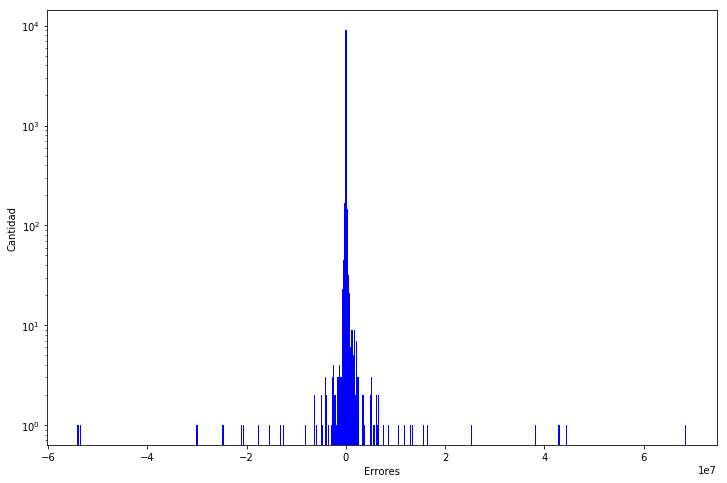

In [42]:
# the histogram of the data
plt.figure(figsize=(12,8))
plt.hist(errores, cant_buckets, facecolor='blue')
plt.xlabel('Errores')
plt.ylabel('Cantidad')
#plt.xlim(-10000000, 10000000) para variar el "zoom a 0"
plt.yscale('log')
plt.show()